## 0. Install Dependencies

In [1]:
#pip install -r requirements.txt

## 1. Data Acquisition & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# load dataset
df = pd.read_csv("data/data.csv")

In [3]:
# check for rows with missing values or rows with duplicates
missing = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"Number of missing rows: {missing}\nNumber of duplicate rows: {duplicates}")

Number of missing rows: 0
Number of duplicate rows: 0


In [4]:
#dropping row if the artist names and song title are the same
df = df.drop_duplicates(subset=['artists', 'name'], keep='first')

## 2. Exploratory Data Analysis (EDA) & Preprocessing

### 2-1. Define audio features
To use the k-Nearest Neighbors (kNN) algorithm, we selected features that **quantitatively** characterize a track's "musical identity". `valence`, `energy`, `danceability`, `acousticness` defines mood and atmosphere. `tempo`, `loudness`, `instrumentalness` defines rhythm and intensity. `year`, `popularity` provides contextual information. 

During the Exploratory Data Analysis (EDA), we identified a subset of data (196 rows) containing zero values for `valence` and `tempo`. We determined these zero values as corrupted data or extraction errors. Since they constitute a negligible portion of the dataset (< 0.12%), we removed these rows to prevent them from distorting the distance calculations in the kNN model.

We retained rows with zero values for `acousticness`, `instrumentalness`, and `popularity` because, unlike tempo or valence where zero indicates data corruption, these zeros carry valid semantic meaning. A value of 0 in acousticness or instrumentalness correctly identifies tracks that are purely electronic or vocal-heavy, while a 0 in popularity represents new or niche releases essential for solving the "cold start" problem.

In [5]:
# print df info to view available columns and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157685 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           157685 non-null  float64
 1   year              157685 non-null  int64  
 2   acousticness      157685 non-null  float64
 3   artists           157685 non-null  object 
 4   danceability      157685 non-null  float64
 5   duration_ms       157685 non-null  int64  
 6   energy            157685 non-null  float64
 7   explicit          157685 non-null  int64  
 8   id                157685 non-null  object 
 9   instrumentalness  157685 non-null  float64
 10  key               157685 non-null  int64  
 11  liveness          157685 non-null  float64
 12  loudness          157685 non-null  float64
 13  mode              157685 non-null  int64  
 14  name              157685 non-null  object 
 15  popularity        157685 non-null  int64  
 16  release_date      157685 

In [6]:
# audio features
audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
    'popularity', 'year'
]

af = df[audio_features]

print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,157685.0,0.504277,0.376070,0.0,0.103,0.522000,0.894,0.996
danceability,157685.0,0.536762,0.176398,0.0,0.414,0.547000,0.668,0.988
energy,157685.0,0.480694,0.267640,0.0,0.254,0.468000,0.701,1.000
instrumentalness,157685.0,0.167909,0.313854,0.0,0.000,0.000224,0.106,1.000
liveness,157685.0,0.206755,0.175506,0.0,0.099,0.136000,0.263,1.000
loudness,157685.0,-11.502779,5.699130,-60.0,-14.669,-10.618000,-7.210,3.855
speechiness,157685.0,0.100937,0.167698,0.0,0.035,0.045300,0.077,0.970
tempo,157685.0,116.799153,30.754080,0.0,93.240,114.726000,135.519,243.507
valence,157685.0,0.527579,0.263225,0.0,0.316,0.538000,0.746,1.000
popularity,157685.0,31.445845,21.957673,0.0,11.000,34.000000,48.000,100.000


In [7]:
# remove corrupted rows
# 'tempo', 'danceability', and 'energy' columns also have 0s, but are a subset of rows with valence == 0
af = af[af['valence']>0]
print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,157504.0,0.504143,0.376024,0.00000,0.103,0.522000,0.89400,0.996
danceability,157504.0,0.537235,0.175755,0.05510,0.415,0.547000,0.66800,0.988
energy,157504.0,0.481074,0.267435,0.00002,0.254,0.468000,0.70100,1.000
instrumentalness,157504.0,0.167499,0.313492,0.00000,0.000,0.000222,0.10500,1.000
liveness,157504.0,0.206682,0.175390,0.00967,0.099,0.136000,0.26300,1.000
loudness,157504.0,-11.487207,5.666405,-54.83700,-14.656,-10.611000,-7.20800,3.744
speechiness,157504.0,0.100993,0.167728,0.02220,0.035,0.045300,0.07700,0.970
tempo,157504.0,116.899549,30.574648,30.94600,93.311,114.767000,135.55125,243.507
valence,157504.0,0.528185,0.262767,0.00001,0.317,0.538000,0.74600,1.000
popularity,157504.0,31.448204,21.947578,0.00000,11.000,34.000000,48.00000,100.000


### 2-2. Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
af_scaled_np = scaler.fit_transform(af)
af_scaled = pd.DataFrame(af_scaled_np, columns=af.columns, index=af.index)
af_scaled

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,year
0,1.270819,-1.469289,-1.009870,2.266416,2.613147,-1.519274,-0.383916,-1.175669,-1.784038,-1.250630,-2.143926
1,0.605966,1.603173,-0.523769,-0.534304,-0.266164,-0.168325,1.872131,-1.830396,1.654758,-1.205066,-2.143926
2,1.214971,-1.190491,-1.178135,2.378063,-0.602558,-0.593463,-0.400013,-0.214575,-1.860152,-1.205066,-2.143926
3,1.230928,-1.492048,-0.643424,-0.534216,0.993891,0.383173,-0.391070,-0.549167,-1.382160,-1.296193,-2.143926
4,1.204334,-0.678414,-1.077176,-0.534299,0.127247,0.245519,-0.375569,-0.498275,-1.047262,-1.341756,-2.143926
...,...,...,...,...,...,...,...,...,...,...,...
170648,-1.115737,1.415412,1.222456,-0.533382,-0.709749,1.373928,-0.076869,-0.388249,0.303748,1.847672,1.672487
170649,-0.792884,1.022819,1.016798,-0.534304,-0.602558,0.964849,-0.241422,0.688038,0.783261,1.665419,1.672487
170650,-1.072122,0.550570,1.409418,-0.534277,0.292594,1.634411,-0.119796,-0.824593,0.414112,2.029925,1.672487
170651,-1.314182,0.761091,0.530697,-0.534280,2.487712,0.763486,1.234189,-1.368607,-1.267991,1.756545,1.672487


In [9]:
df_clean = df.loc[af.index]

meta_cols = ['name', 'artists', 'id', 'release_date']
df_meta = df_clean[meta_cols]

df_final = pd.concat([df_meta, af_scaled], axis=1)

## 3. PCA & Visualization

최적의 k를 찾는 중입니다... (잠시만 기다려주세요)


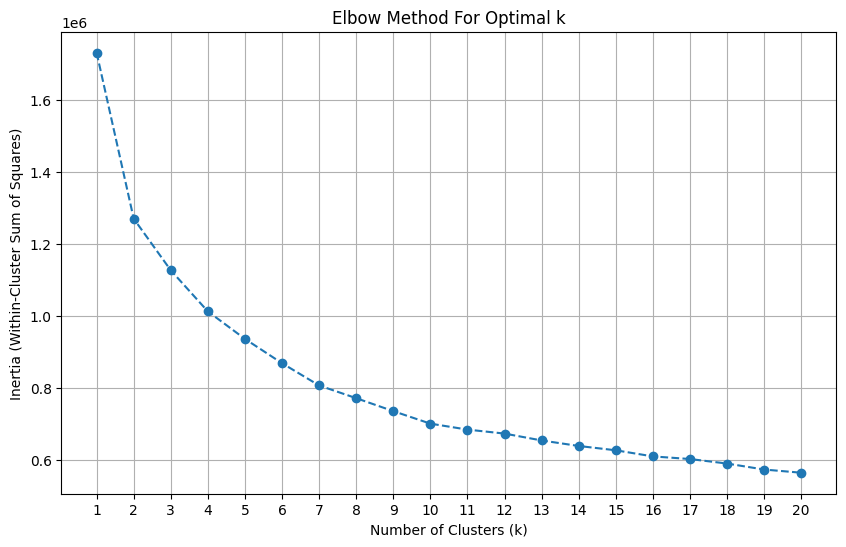

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Inertia(응집도) 계산
inertia = []
K_range = range(1, 21) # 1개부터 20개까지 시도

print("최적의 k를 찾는 중입니다... (잠시만 기다려주세요)")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(af_scaled)
    inertia.append(kmeans.inertia_)

# 2. 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

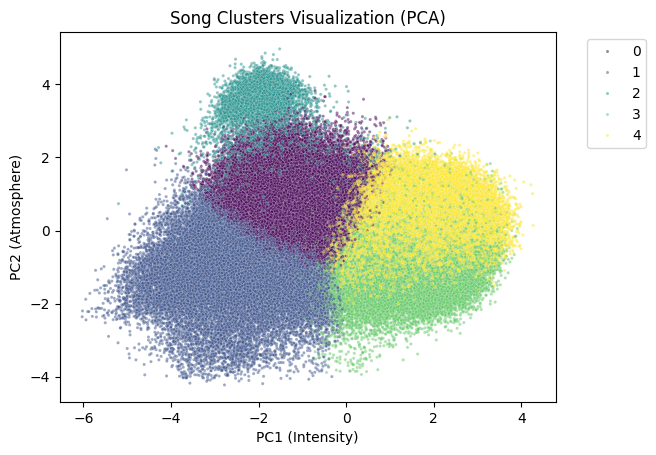

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Clustering (비슷한 노래끼리 색칠하기)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(af_scaled) # 스케일링 된 데이터 사용

# 2. PCA (2차원으로 압축)
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(af_scaled)

# 3. 시각화 준비
pca_df = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['name'] = df_final['name'].values # 마우스 오버용 이름

# 4. 그리기
plt.figure()
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='Cluster', palette='viridis',
    alpha=0.5, s=5
)
plt.title('Song Clusters Visualization (PCA)')
plt.xlabel('PC1 (Intensity)')
plt.ylabel('PC2 (Atmosphere)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

검색된 노래: IDOL - ['BTS']

🎶 'IDOL' 추천 리스트:

                                            name  \
140335                                      IDOL   
37971                       As If It's Your Last   
170602                               Outro : Ego   
155455                                 Hot Stuff   
92235   Tinted Eyes (feat. blackbear & 24kGoldn)   

                                   artists  Distance  
140335              ['BTS', 'Nicki Minaj']  0.455379  
37971                        ['BLACKPINK']  0.510203  
170602                             ['BTS']  0.655026  
155455            ['Kygo', 'Donna Summer']  0.686002  
92235   ['DVBBS', '24kGoldn', 'blackbear']  0.694197  


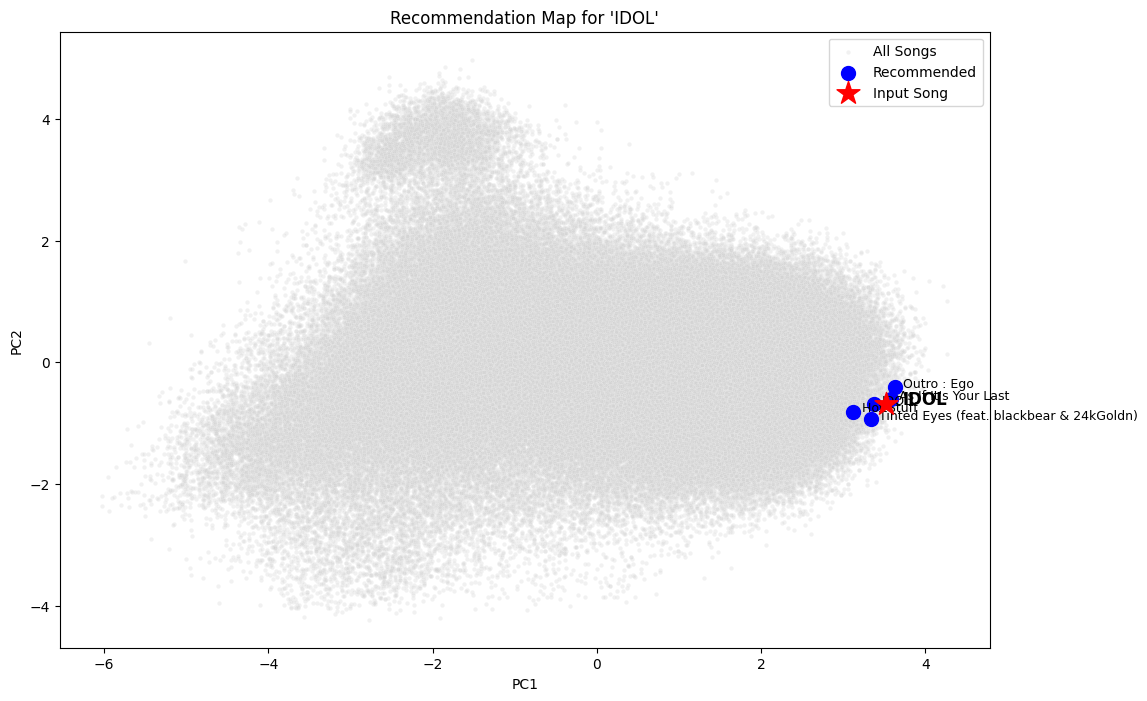

In [12]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# [중요] 중복이 제거된 깔끔한 데이터로 kNN 모델 다시 학습
# n_neighbors=6 : 나 자신(1개) + 친구들(5개) = 총 6개만 찾으면 됨
knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
knn.fit(af_scaled)

def recommend_song(song_name, artist_name=None):
    # --- (1) 노래 찾기 (제목 + 가수 옵션) ---
    try:
        # 1. 제목 검색 (소문자 변환)
        search_mask = df_final['name'].str.lower() == song_name.lower()
        
        # 2. 가수 이름이 입력되었다면 추가 필터링
        if artist_name:
            search_mask = search_mask & df_final['artists'].str.lower().str.contains(artist_name.lower())
        
        # 검색 실행
        found_songs = df_final[search_mask]
        
        if len(found_songs) == 0:
            print(f"Error: '{song_name}' (Artist: {artist_name}) 노래를 찾을 수 없습니다.")
            return
        
        # 검색 결과 중 첫 번째 곡 선택 (중복이 제거되었으므로 신뢰)
        target_idx = found_songs.index[0]
        
        print(f"검색된 노래: {df_final.loc[target_idx, 'name']} - {df_final.loc[target_idx, 'artists']}")
        
    except IndexError:
        print(f"Error: 검색 중 문제가 발생했습니다.")
        return

    # --- (2) 유사한 노래 5곡 찾기 ---
    input_features = af_scaled.loc[[target_idx]]
    distances, indices = knn.kneighbors(input_features)
    
    # 0번은 자기 자신이므로 제외하고 1번부터 5개 가져오기
    neighbor_indices = indices[0][1:]
    neighbor_dists = distances[0][1:]
    
    # 추천된 노래들의 실제 인덱스(고유 번호) 가져오기
    # indices는 '몇 번째 줄'인지 알려주므로, 실제 index로 변환 필요
    rec_real_indices = af_scaled.index[neighbor_indices]
    
    # --- (3) 결과 출력 ---
    print(f"\n🎶 '{df_final.loc[target_idx, 'name']}' 추천 리스트:\n")
    rec_df = df_final.loc[rec_real_indices][['name', 'artists']]
    rec_df['Distance'] = neighbor_dists
    print(rec_df)

    # --- (4) 시각화 (PCA 지도) ---
    plt.figure(figsize=(12, 8))
    
    # 배경 (전체 노래)
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, color='lightgray', alpha=0.3, s=10, label='All Songs')
    
    # 추천된 노래 (파란 점)
    rec_pca = pca_df.iloc[neighbor_indices] # neighbor_indices는 순서(position)이므로 iloc 사용 가능
    plt.scatter(rec_pca['PC1'], rec_pca['PC2'], c='blue', s=100, label='Recommended')
    
    # 입력한 노래 (빨간 별)
    target_position = af_scaled.index.get_loc(target_idx) # 순서 찾기
    input_pca = pca_df.iloc[target_position]
    plt.scatter(input_pca['PC1'], input_pca['PC2'], c='red', marker='*', s=300, zorder=10, label='Input Song')
    
    # 텍스트 라벨
    plt.text(input_pca['PC1']+0.2, input_pca['PC2'], input_pca['name'], fontsize=12, fontweight='bold')
    for i, row in rec_pca.iterrows():
        plt.text(row['PC1']+0.1, row['PC2'], row['name'], fontsize=9)

    plt.title(f"Recommendation Map for '{df_final.loc[target_idx, 'name']}'")
    plt.legend()
    plt.show()

# --- 테스트 ---
# 이제 'Idol'을 검색해도 BTS 곡인지, 다른 곡인지 가수로 구분해서 찾을 수 있습니다.
recommend_song("idol", 'bts')

# 여기부턴 공사중
남은거: PCA, kNN 구현, 결과 시각화, 모델 성능 평가

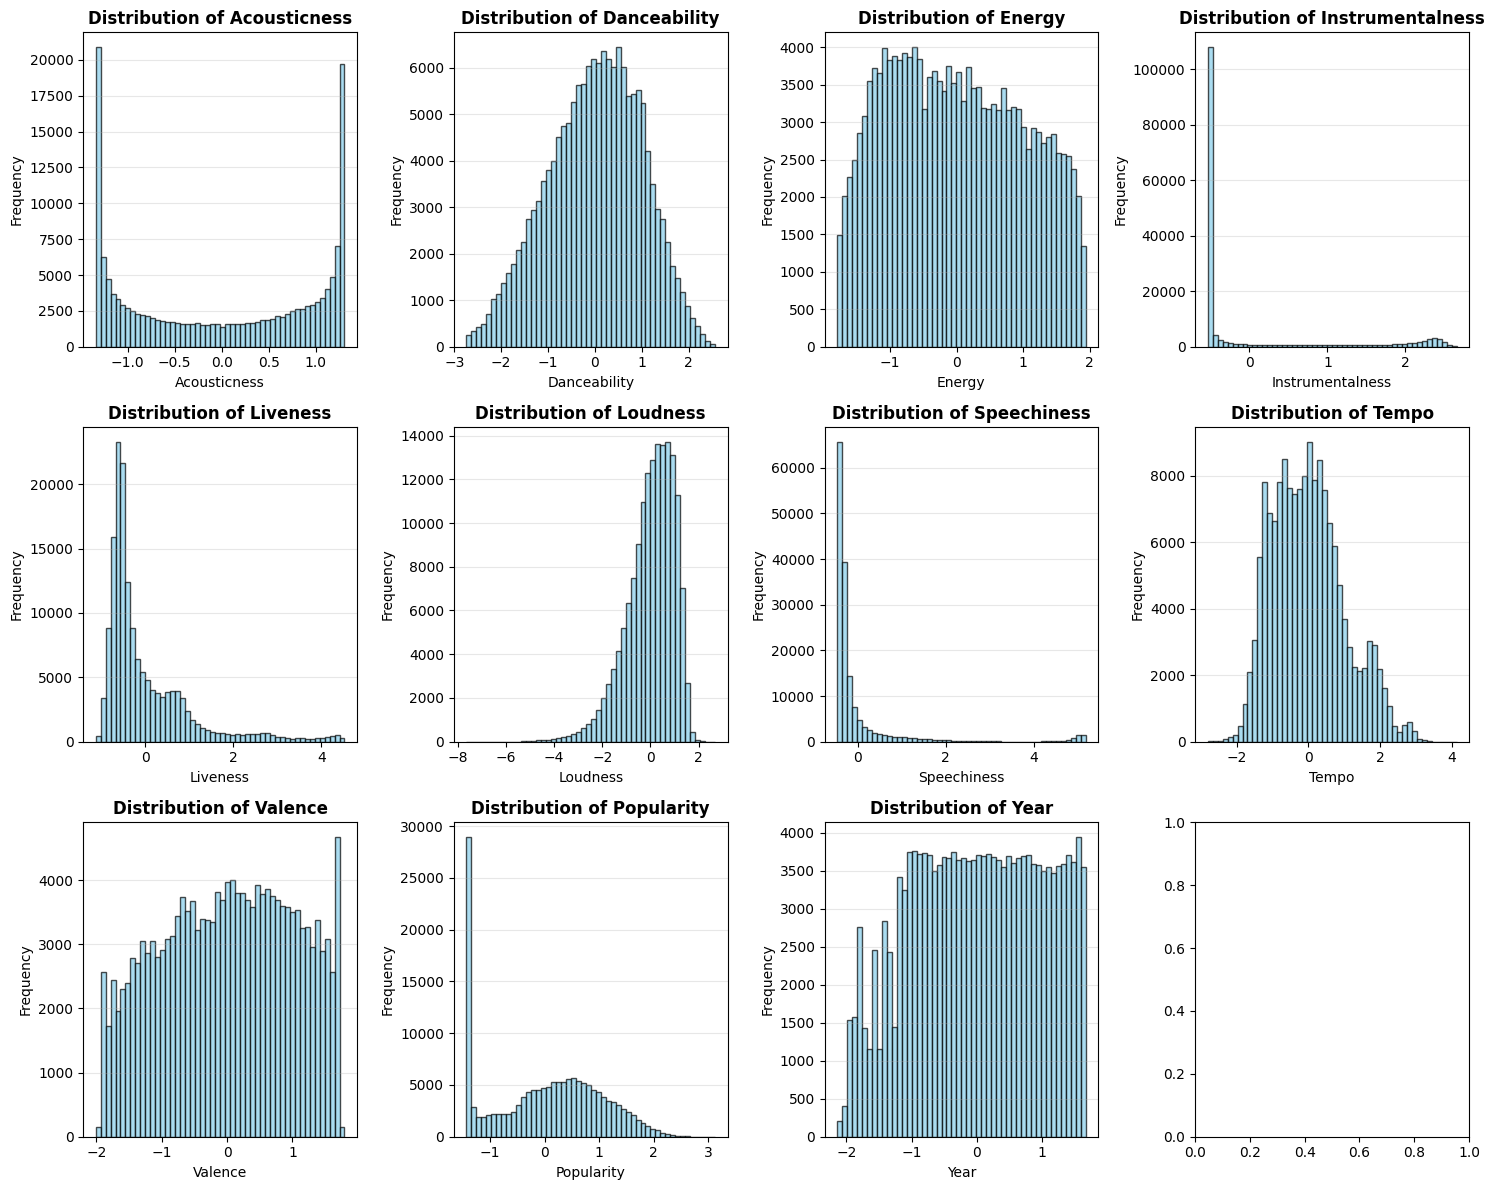

In [13]:
# Plot distributions
# necessary??
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(af_scaled[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

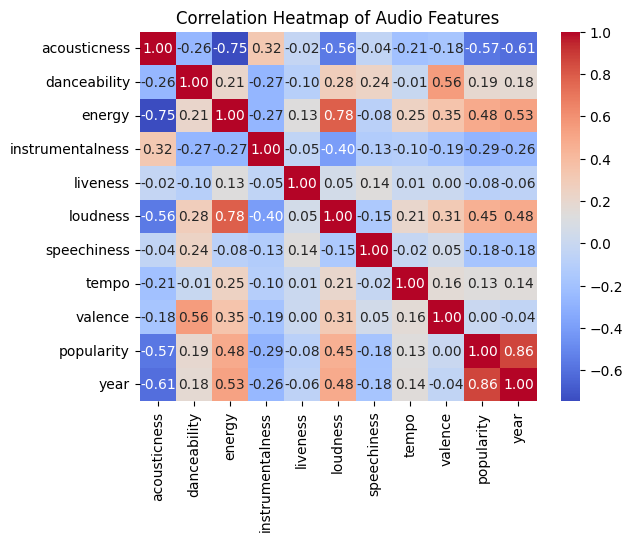

In [14]:
# necessary???
import seaborn as sns

plt.figure()
correlation_matrix = af_scaled[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

In [15]:
print(" Strong Correlations (|r| > 0.5):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            strong_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

pd.DataFrame(strong_corr).sort_values('Correlation', ascending=False)

 Strong Correlations (|r| > 0.5):


,Feature 1,Feature 2,Correlation
7,popularity,year,0.863661
5,energy,loudness,0.782320
4,danceability,valence,0.556079
6,energy,year,0.526733
1,acousticness,loudness,-0.559041
2,acousticness,popularity,-0.571080
3,acousticness,year,-0.609415
0,acousticness,energy,-0.747261


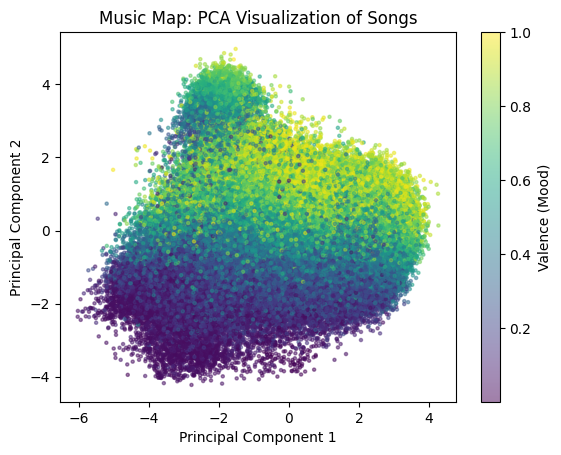

In [16]:
# 1. PCA 모델 생성 (2차원으로 축소)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(af_scaled)

# 2. 시각화 (Scatter Plot)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=af['valence'], cmap='viridis', s=5, alpha=0.5)
plt.colorbar(label='Valence (Mood)')
plt.title("Music Map: PCA Visualization of Songs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 설명: 점 하나가 노래 한 곡입니다.
# 색깔(Valence)은 노래의 밝기(Mood)를 나타냅니다.
# 비슷한 색깔끼리 뭉쳐 있다면, 특징별로 잘 정렬된 것입니다.

Testing different numbers of clusters:
k=2: Inertia=1270817.77, Silhouette=0.249
k=3: Inertia=1127105.48, Silhouette=0.272
k=4: Inertia=1012776.18, Silhouette=0.208
k=5: Inertia=936289.27, Silhouette=0.164
k=6: Inertia=868652.22, Silhouette=0.168
k=7: Inertia=806750.52, Silhouette=0.172
k=8: Inertia=767631.94, Silhouette=0.166
k=9: Inertia=732565.40, Silhouette=0.166
k=10: Inertia=700583.35, Silhouette=0.155


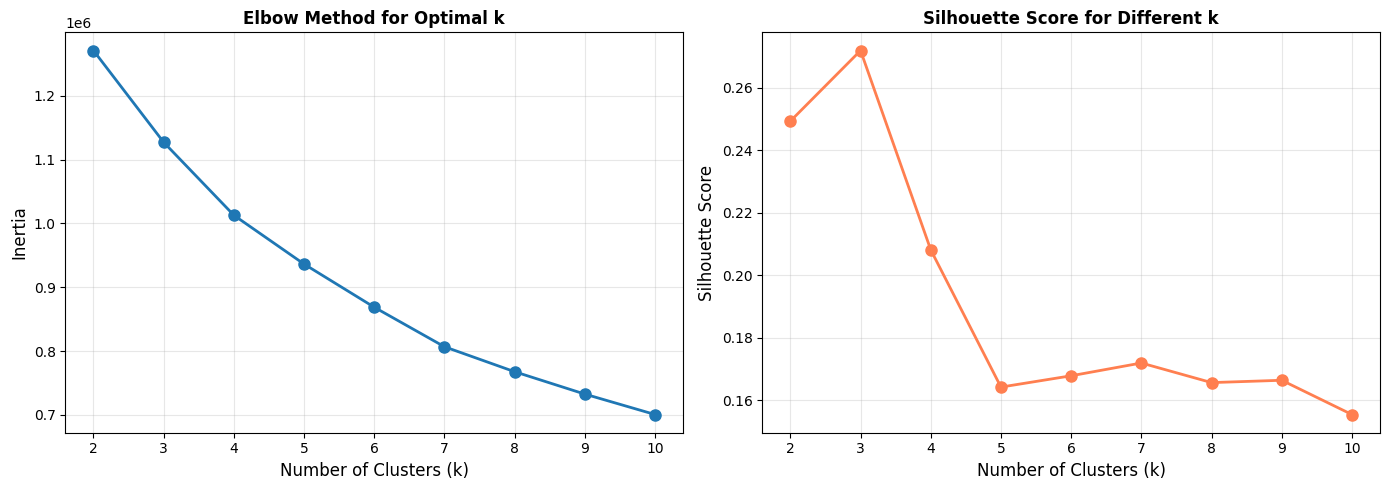


✅ Clustering analysis completed!


In [17]:
# Clustering analysis 이거 copy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # ✅ 2~10으로 줄임

print("Testing different numbers of clusters:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(af_scaled_np)  # ✅ numpy array 사용
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on a sample for speed)
    sample_size = min(10000, len(af_scaled_np))  # ✅ 통일
    sample_idx = np.random.choice(len(af_scaled_np), sample_size, replace=False)
    silhouette = silhouette_score(af_scaled_np[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Clustering analysis completed!")

Testing different numbers of clusters:
k=2: Inertia=416779.20, Silhouette=0.458
k=3: Inertia=288699.17, Silhouette=0.434
k=4: Inertia=223795.97, Silhouette=0.374
k=5: Inertia=181529.63, Silhouette=0.357
k=6: Inertia=152605.21, Silhouette=0.356
k=7: Inertia=129540.74, Silhouette=0.349
k=8: Inertia=114971.41, Silhouette=0.341
k=9: Inertia=102599.98, Silhouette=0.341
k=10: Inertia=92690.78, Silhouette=0.340


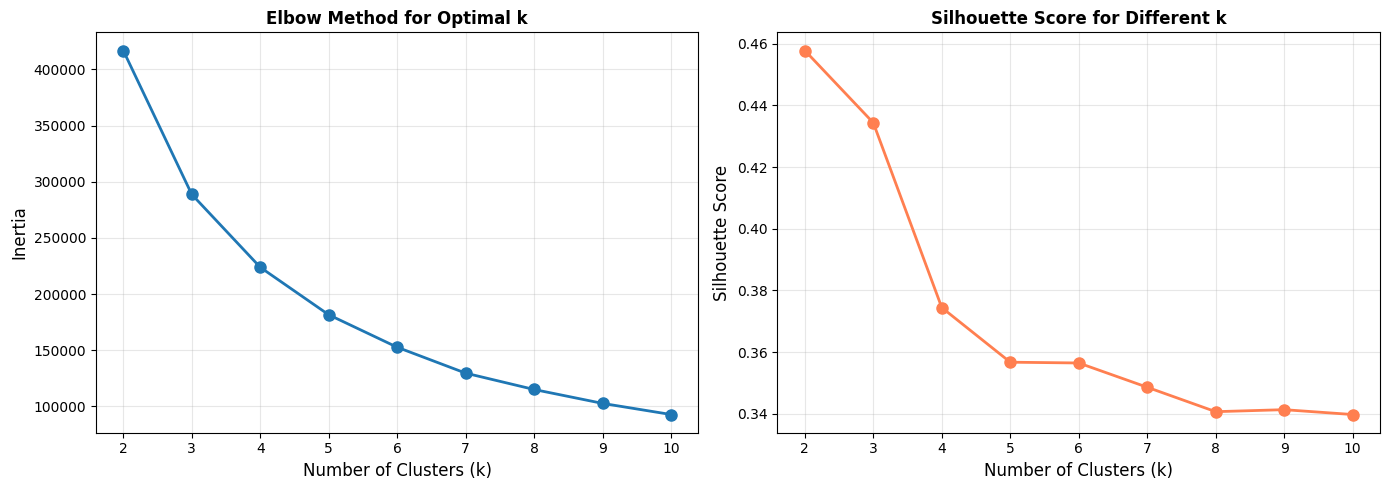


✅ Clustering analysis completed!


In [18]:
# Clustering analysis
#PCA 결과로
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # ✅ 2~10으로 줄임

print("Testing different numbers of clusters:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)  # ✅ numpy array 사용
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on a sample for speed)
    sample_size = min(10000, len(X_pca ))  # ✅ 통일
    sample_idx = np.random.choice(len(X_pca ), sample_size, replace=False)
    silhouette = silhouette_score(X_pca[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Clustering analysis completed!")

In [19]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. K-Means Clustering (k=3)
# ✅ df_clean 사용 (af와 같은 길이)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(af_scaled_np)

print(f"Cluster distribution:")
print(df_clean['cluster'].value_counts())

# 2. Cluster-based kNN 함수
def get_recommendations(artist, title, k=5):
    """
    ✅ 모든 변수 명확하게 정의
    """
    
    # 노래 찾기 (df_clean에서!)
    song = df_clean[(df_clean['artists'].str.contains(artist, case=False, na=False)) & 
                    (df_clean['name'].str.contains(title, case=False, na=False))]
    
    if len(song) == 0:
        return "Song not found!"
    
    # ✅ df_clean의 실제 index 사용
    idx = song.index[0]
    cluster = df_clean.loc[idx, 'cluster']
    
    # ✅ 같은 cluster의 row들
    cluster_mask = df_clean['cluster'] == cluster
    cluster_df = df_clean[cluster_mask]
    
    # ✅ numpy array에서 같은 index 위치 찾기
    # df_clean의 index를 af_scaled_np의 위치로 변환
    cluster_positions = np.where(cluster_mask)[0]
    cluster_features = af_scaled_np[cluster_positions]
    
    # ✅ input song의 위치 찾기
    input_position = df_clean.index.get_loc(idx)
    
    # kNN
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn.fit(cluster_features)
    
    # ✅ input song의 features (cluster 내에서의 위치)
    input_cluster_position = np.where(cluster_positions == input_position)[0][0]
    distances, indices = knn.kneighbors(cluster_features[input_cluster_position].reshape(1, -1))
    
    # 결과 (자기 자신 제외)
    result_positions = cluster_positions[indices[0][1:]]
    result_indices = df_clean.index[result_positions]
    
    return df_clean.loc[result_indices, ['artists', 'name', 'year']]

# 사용
print(get_recommendations("frank sinatra", "i love you baby", k=5))

Cluster distribution:
cluster
0    87279
1    64573
2     5652
Name: count, dtype: int64
Song not found!
